<a href="https://colab.research.google.com/github/fiapostechfase1/tech-challenge2/blob/main/tech_challenge_fase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Resumo do Desafio: Tech Challenge - Fase 2: (Modelo Preditivo do Índice BOVESPA)**

##**Objetivo**

* Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice.
* Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

##**Base de Dados**

Dados históricos do índice IBOVESPA, disponíveis
publicamente:

[Dados Históricos Ibovespa](https://br.investing.com/indices/bovespa-historical-data)

* Selecione o período “diário”.

* Baixe um intervalo de pelo menos 2 anos de dados.

* Realize o pré-processamento necessário para utilizar os dados no modelo

##**Requisitos**



* **Seu modelo deve prever a tendência (↑ ou ↓) com acuracidade mínima
de 75% em um conjunto de teste.**

* O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

##**Entregas Esperadas**:

Você deverá apresentar ao time de investimentos:

Storytelling Técnico

Apresentação com os seguintes requisitos:

* Aquisição e exploração dos dados;

* Estratégia de engenharia de atributos, caso seja realizado (por
exemplo: variações, médias móveis, etc)

* Preparação da base para previsão (definição de target, janela de
tempo, etc.);

* Escolha e justificativa do modelo utilizado;

* Resultados e análise de métricas que garantem que o modelo está
confiável.

**Justificativa Técnica**

Explique claramente:

* Por que você escolheu o(s) modelo(s) utilizados (ex: árvores,
regressão logística, LSTM, etc.);

* Como tratou a natureza sequencial dos dados (ex: janelas deslizantes,
features lagged);

* Quais os trade-offs entre acuracidade e overfitting.

##**Descritivo Colunas**

* ultimo (Último): Representa o nível do índice no encerramento do dia. Sua

* análise foca na tendência de longo prazo e nas flutuações diárias do valor.

* abertura (Abertura): Indica o nível inicial do índice no começo do pregão. Observa-se a diferença para o fechamento anterior para entender a reação inicial do mercado.

* maxima (Máxima):O ponto mais alto que o índice alcançou durante o dia. Ajuda a entender a extensão positiva dos movimentos do Ibovespa em um período.

* minima (Mínima):O ponto mais baixo que o índice registrou no dia. Complementa a "Máxima" para definir a amplitude de variação do índice no pregão.

* volume (Vol.): A quantidade de capital movimentado no índice durante o dia. Reflete o nível de atividade e o interesse dos investidores, influenciando a liquidez do mercado.

* variacao (Var%): O desempenho percentual do índice em relação ao dia anterior. É chave para medir o movimento diário do Ibovespa e seu grau de oscilação (volatilidade).

#**Bibliotecas**

<p>Inserimos aqui as bibliotecas que serão utilizadas para a execução do projeto.</p>

In [340]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#**Dados**

<p>Realizando a importação dos dados e as primeiras visualizações.</p>

In [341]:
dados = pd.read_csv("/content/Dados Históricos - Ibovespa_10anos.csv", sep=',')

In [342]:
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.07.2025,136.743,137.472,137.472,136.014,"9,57M","-0,54%"
1,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
2,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
3,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"


In [343]:
dados.shape

(2480, 7)

In [344]:
dados.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


#**Transformação dos dados**


<p>Aqui fazemos os tratamentos dos dados necessários para realizar a exploração e visualização dos dados, e por fim, o teste e treinamento dos modelos de Machine Learning.</p>

## **Alterar o Nome das Colunas**

In [345]:
#Alterar o nome de todas as colunas por meio de um dicionario

rename_dict = {
    'Data': 'data',
    'Último': 'ultimo',
    'Abertura': 'abertura',
    'Máxima': 'maxima',
    'Mínima': 'minima',
    'Vol.': 'volume',
    'Var%': 'variacao'
}

dados = dados.rename(columns=rename_dict)
dados.head()


,data,ultimo,abertura,maxima,minima,volume,variacao
0,10.07.2025,136.743,137.472,137.472,136.014,"9,57M","-0,54%"
1,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
2,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
3,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"


In [346]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   data      2480 non-null   object 
 1   ultimo    2480 non-null   float64
 2   abertura  2480 non-null   float64
 3   maxima    2480 non-null   float64
 4   minima    2480 non-null   float64
 5   volume    2479 non-null   object 
 6   variacao  2480 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.8+ KB


## **Transformar Data de Object para Date**

In [347]:
#transformar data de object para date
dados['data'] = pd.to_datetime(dados['data'], format='%d.%m.%Y')

# Função para converter volume string to float (handling 'B' for billions)
def convert_volume(volume_str):
  if isinstance(volume_str, str):
    volume_str = volume_str.replace('.', '').replace(',', '.')
    if 'B' in volume_str:
      return float(volume_str.replace('B', '')) * 1e9
    elif 'M' in volume_str:
        return float(volume_str.replace('M', '')) * 1e6
  try:
    return float(volume_str)
  except (ValueError, TypeError):
    return np.nan # Handle potential errors

dados['volume'] = dados['volume'].apply(convert_volume).astype('float64')

# Converte 'variacao' para float e remove '%' simbolo.
dados['variacao'] = dados['variacao'].str.replace('%', '').str.replace(',', '.').astype('float')

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      2480 non-null   datetime64[ns]
 1   ultimo    2480 non-null   float64       
 2   abertura  2480 non-null   float64       
 3   maxima    2480 non-null   float64       
 4   minima    2480 non-null   float64       
 5   volume    2475 non-null   float64       
 6   variacao  2480 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 135.8 KB


In [348]:
print(dados.head())
print(dados.tail())

        data   ultimo  abertura   maxima   minima        volume  variacao
0 2025-07-10  136.743   137.472  137.472  136.014  9.570000e+06     -0.54
1 2025-07-09  137.481   139.303  139.331  137.299  7.580000e+09     -1.31
2 2025-07-08  139.303   139.491  139.591  138.770  6.750000e+09     -0.13
3 2025-07-07  139.490   141.265  141.342  139.295  6.120000e+09     -1.26
4 2025-07-04  141.264   140.928  141.564  140.597  3.310000e+09      0.24
           data  ultimo  abertura  maxima  minima     volume  variacao
2475 2015-07-17  52.342    53.070  53.310  52.221  2520000.0     -1.37
2476 2015-07-16  53.070    52.902  53.417  52.714  2140000.0      0.32
2477 2015-07-15  52.902    53.239  53.334  52.790  2610000.0     -0.63
2478 2015-07-14  53.239    53.119  53.416  52.653  2740000.0      0.23
2479 2015-07-13  53.119    52.591  53.164  52.591  2690000.0      1.00


# **Adição de Features**

<p>Aqui criamos as variáveis que servirão de apoio para o modelo preditor.</p>

## fechamento_dia_seguinte



In [349]:
# Criando variável target e auxiliar para identificar se houve queda, aumento ou permanência nos valores da bolsa
dados['fechamento_dia_seguinte'] = dados['ultimo'].shift(+1)
dados['subiu'] = (dados['fechamento_dia_seguinte'] > dados['ultimo']).astype(int)

# Exclui o dia mais recente, pois não possui um valor para definir se subiu ou não. Dessa forma, pode influenciar na acuracidade do modelo
dados.dropna(inplace=True)

# Visualizar
print(dados.head())
print(dados.tail())

        data   ultimo  abertura   maxima   minima        volume  variacao  \
1 2025-07-09  137.481   139.303  139.331  137.299  7.580000e+09     -1.31   
2 2025-07-08  139.303   139.491  139.591  138.770  6.750000e+09     -0.13   
3 2025-07-07  139.490   141.265  141.342  139.295  6.120000e+09     -1.26   
4 2025-07-04  141.264   140.928  141.564  140.597  3.310000e+09      0.24   
5 2025-07-03  140.928   139.051  141.304  139.051  6.080000e+09      1.35   

   fechamento_dia_seguinte  subiu  
1                  136.743      0  
2                  137.481      0  
3                  139.303      0  
4                  139.490      0  
5                  141.264      1  
           data  ultimo  abertura  maxima  minima     volume  variacao  \
2475 2015-07-17  52.342    53.070  53.310  52.221  2520000.0     -1.37   
2476 2015-07-16  53.070    52.902  53.417  52.714  2140000.0      0.32   
2477 2015-07-15  52.902    53.239  53.334  52.790  2610000.0     -0.63   
2478 2015-07-14  53.239  

# **Visualização dos Dados**

<p>Alguns gráficos que auxiliam na compreensão do comportamento dos dados, como, frequência, outliers e correlação.</p>

## **Histograma**

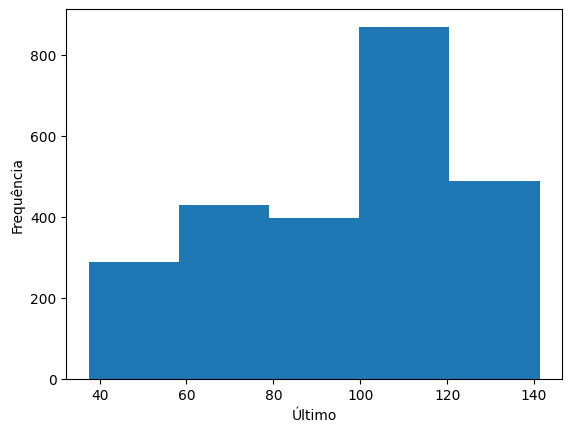

In [350]:
# histograma para identificar a frquencia dos valores da base de dados
plt.hist(dados['ultimo'],bins=5)
plt.xlabel('Último')
plt.ylabel('Frequência')
plt.show()

## **Boxplot**

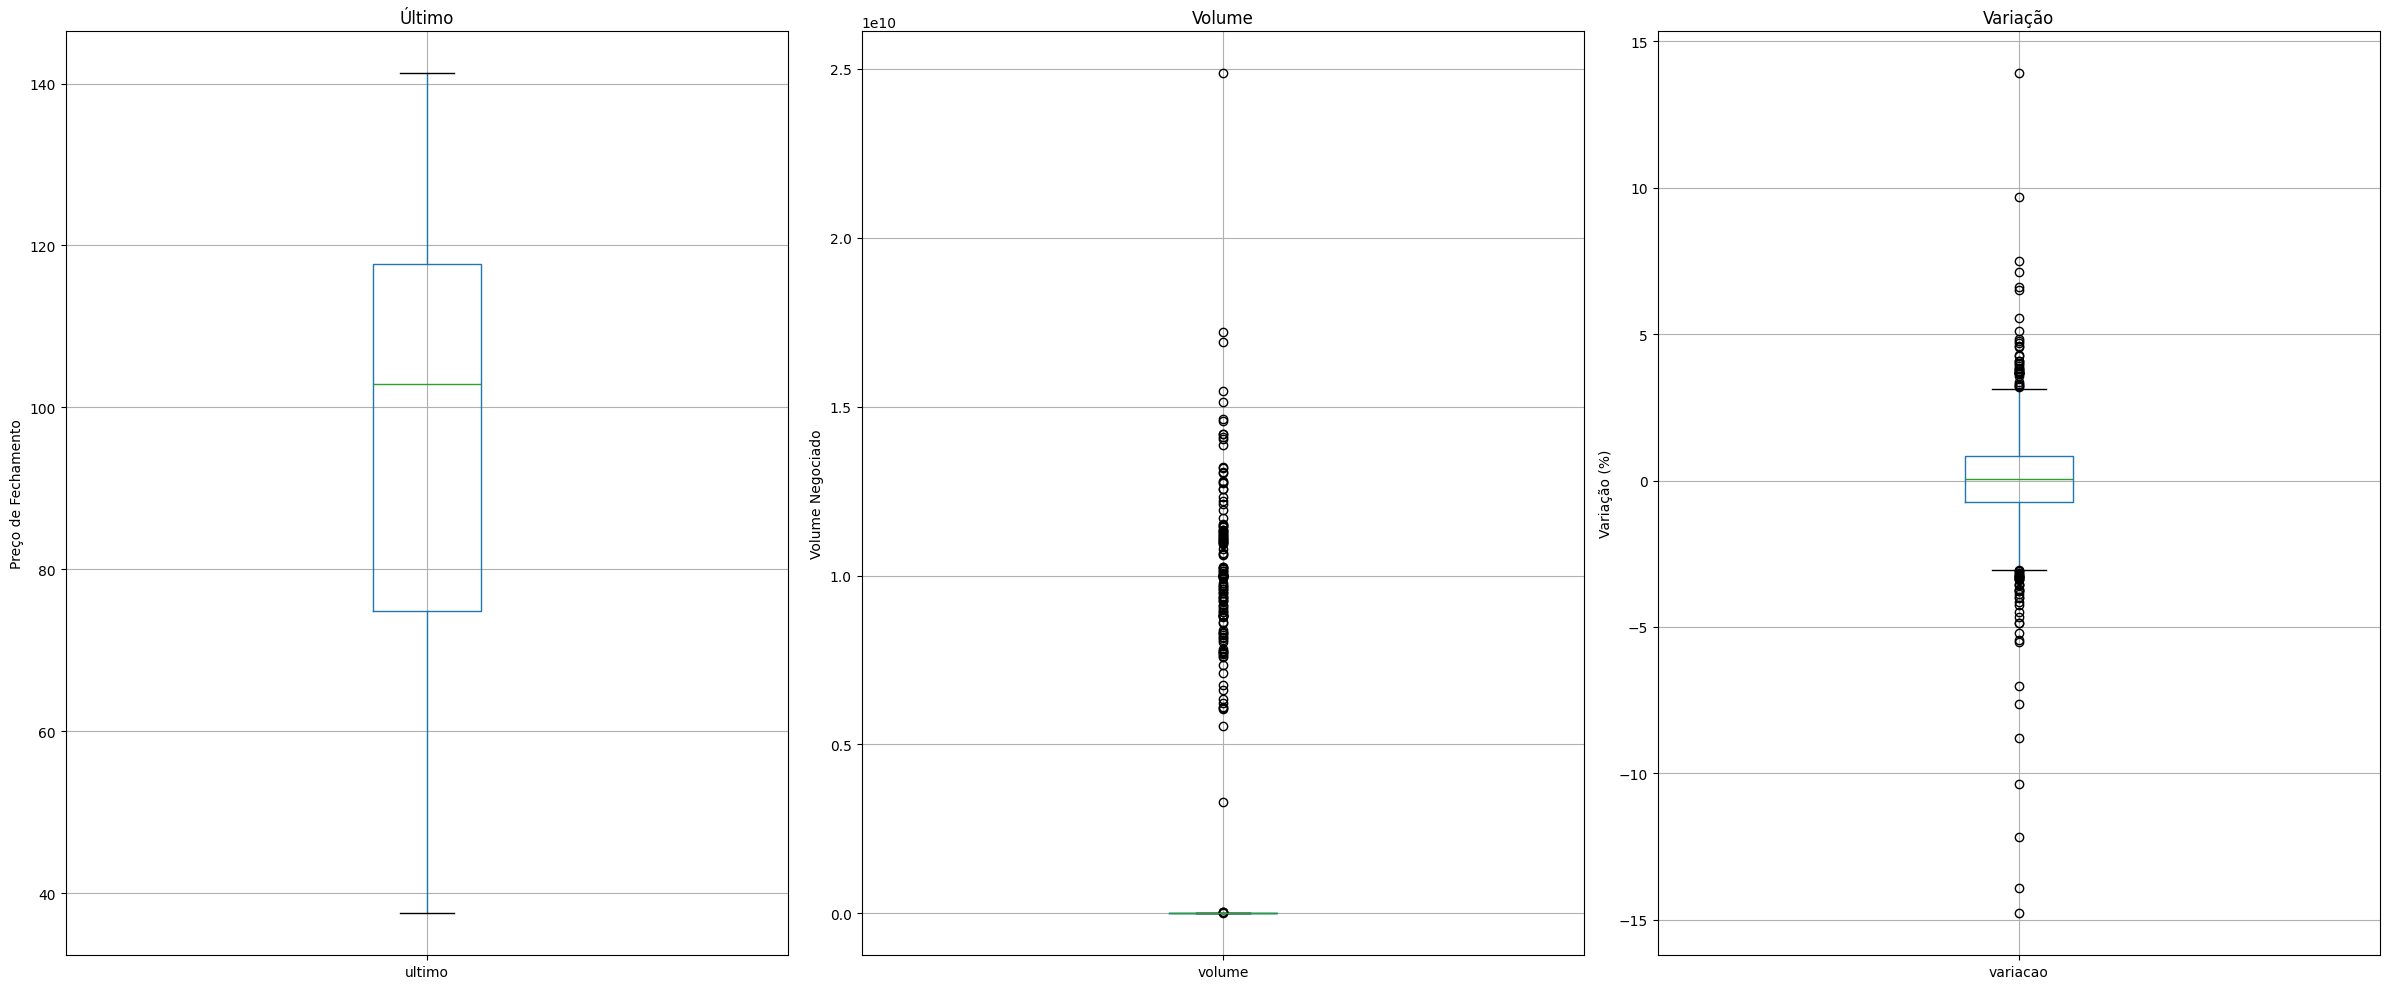

In [351]:
plt.figure(figsize=(24, 10))

# Boxplot do 'ultimo'
plt.subplot(1, 3, 1)
dados.boxplot(column=['ultimo'])
plt.title('Último')
plt.ylabel('Preço de Fechamento')

# Boxplot do 'volume'
plt.subplot(1, 3, 2)
dados.boxplot(column=['volume'])
plt.title('Volume')
plt.ylabel('Volume Negociado')

# Boxplot da 'variacao'
plt.subplot(1, 3, 3)
dados.boxplot(column=['variacao'])
plt.title('Variação')
plt.ylabel('Variação (%)')

plt.tight_layout()
plt.show()

## **Matrix de correlação**

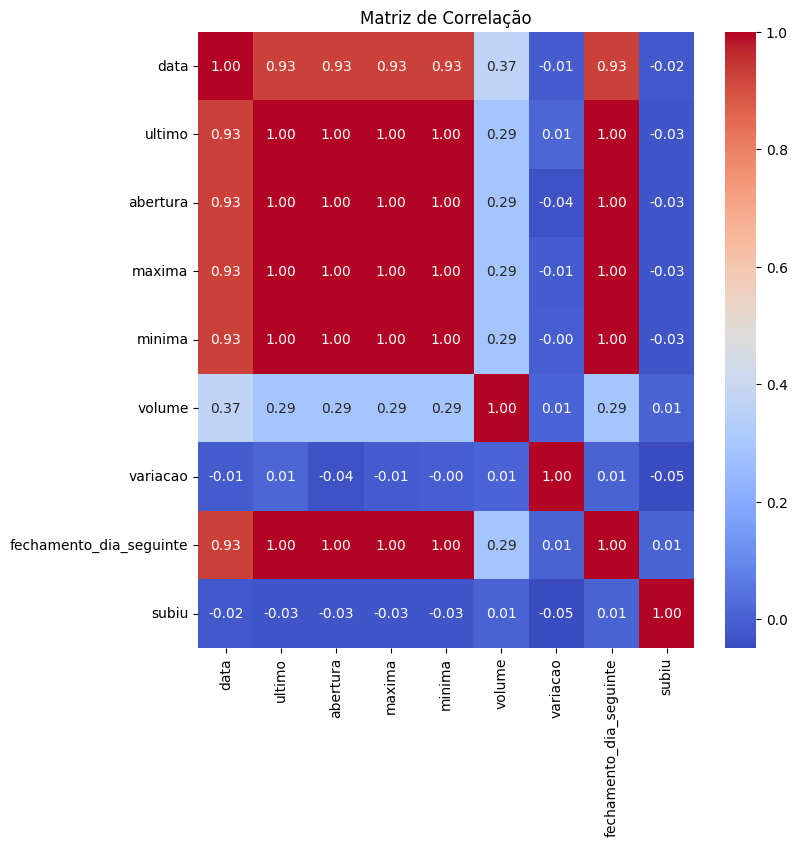

In [352]:
# gerando uma matriz de correlação para entender como as variáveis se conversam
correlation_matrix = dados.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

#**Modelos**

<p>Nessa etapa fazemos o teste e o treinamento dos modelos com os recursos desenvolvidos até o momento.</p>

## **Novas Features**

* ultimo_d-1, ultimo_d-2, ultimo_d-5:
Preços de fechamento (último valor negociado) defasados em 1, 2 e 5 dias. Permitem capturar tendências e comparações com valores recentes.

* variacao_d-1, variacao_d-2:
Variação percentual do índice nos dias anteriores. Indicam se houve alta ou baixa no curto prazo, podendo sinalizar reversões ou continuidade.

* volume_change:
Variação percentual do volume negociado em relação ao dia anterior. Ajuda a medir o interesse do mercado e pode antecipar movimentos de preço mais intensos.

* momentum_3, momentum_5, momentum_10, momentum_15:
Diferença entre o preço atual e o de 3, 5, 10 e 15 dias atrás. Indicam força da tendência e ajudam o modelo a identificar períodos de aceleração ou desaceleração.

* sma_3, sma_5, sma_10, sma_20:
Médias móveis simples de 3, 5, 10 e 20 dias. Suavizam as flutuações de curto prazo e ajudam a captar tendências estáveis do mercado.

* sma_ratio:
Razão entre médias móveis de períodos diferentes (ex: sma_3 / sma_10). Ajuda a identificar cruzamentos e pontos de inflexão entre tendências de curto e médio prazo.

* amplitude_d-1:
Diferença entre a máxima e a mínima do dia anterior. Mede a volatilidade intradiária, que pode sinalizar incerteza ou oportunidades de reversão.

* rsi_ratio:
Variação do índice de força relativa (RSI) em comparação com o período anterior. Ajuda a detectar regiões de sobrecompra ou sobrevenda no mercado.

In [353]:
# LAGs
dados['ultimo_d-1'] = dados['ultimo'].shift(1)
dados['ultimo_d-2'] = dados['ultimo'].shift(2)
dados['ultimo_d-5'] = dados['ultimo'].shift(5)

dados['variacao_d-1'] = dados['variacao'].shift(1)
dados['variacao_d-2'] = dados['variacao'].shift(2)

dados['volume_d-1'] = dados['volume'].shift(1)
dados['volume_d-3'] = dados['volume'].shift(3)

#
dados['volume_change'] = dados['volume'] - dados['volume'].shift(1)

# Momentum
dados['momentum_3'] = dados['ultimo'] - dados['ultimo'].shift(3)
dados['momentum_5'] = dados['ultimo'] - dados['ultimo'].shift(5)
dados['momentum_10'] = dados['ultimo'] - dados['ultimo'].shift(10)
dados['momentum_15'] = dados['ultimo'] - dados['ultimo'].shift(15)

# SMA
dados['sma_3'] = dados['ultimo'].rolling(3).mean().shift(1)
dados['sma_5'] = dados['ultimo'].rolling(5).mean().shift(1)
dados['sma_10'] = dados['ultimo'].rolling(10).mean().shift(1)
dados['sma_20'] = dados['ultimo'].rolling(20).mean().shift(1)

# Compara a média móvel de 5 dias com a de 20 dias.
dados['sma_ratio'] = dados['sma_3'] / dados['sma_20']

# Amplitude
dados['amplitude_d-1'] = (dados['maxima'] - dados['minima']).shift(1)

# RSI
for janela in [7, 14]:
    delta = dados['ultimo'].diff()
    ganhos = delta.clip(lower=0)
    perdas = -delta.clip(upper=0)

    media_ganhos = ganhos.rolling(janela).mean()
    media_perdas = perdas.rolling(janela).mean()
    rs = media_ganhos / media_perdas
    dados[f'rsi_{janela}'] = 100 - (100 / (1 + rs))

# Compara a força relativa de curto prazo com a de médio prazo.
dados['rsi_ratio'] = dados['rsi_7'] / dados['rsi_14']

dados = dados.dropna().reset_index(drop=True)

In [354]:
print(dados.head())
print(dados.tail())

        data   ultimo  abertura   maxima   minima        volume  variacao  \
0 2025-06-10  136.436   135.716  137.369  135.716  8.190000e+09      0.54   
1 2025-06-09  135.699   136.102  136.106  134.119  7.760000e+09     -0.30   
2 2025-06-06  136.102   136.236  136.890  135.601  9.120000e+09     -0.10   
3 2025-06-05  136.236   137.003  137.451  136.031  9.480000e+09     -0.56   
4 2025-06-04  137.002   137.547  138.797  136.695  1.020000e+10     -0.40   

   fechamento_dia_seguinte  subiu  ultimo_d-1  ...  momentum_15       sma_3  \
0                  137.128      1     137.128  ...       -2.615  137.380333   
1                  136.436      1     136.436  ...       -3.850  137.121333   
2                  135.699      0     135.699  ...       -2.753  136.421000   
3                  136.102      0     136.102  ...       -0.630  136.079000   
4                  136.236      0     136.236  ...       -0.112  136.012333   

      sma_5    sma_10     sma_20  sma_ratio  amplitude_d-1    

## **Matriz de Correlação das Novas Features**

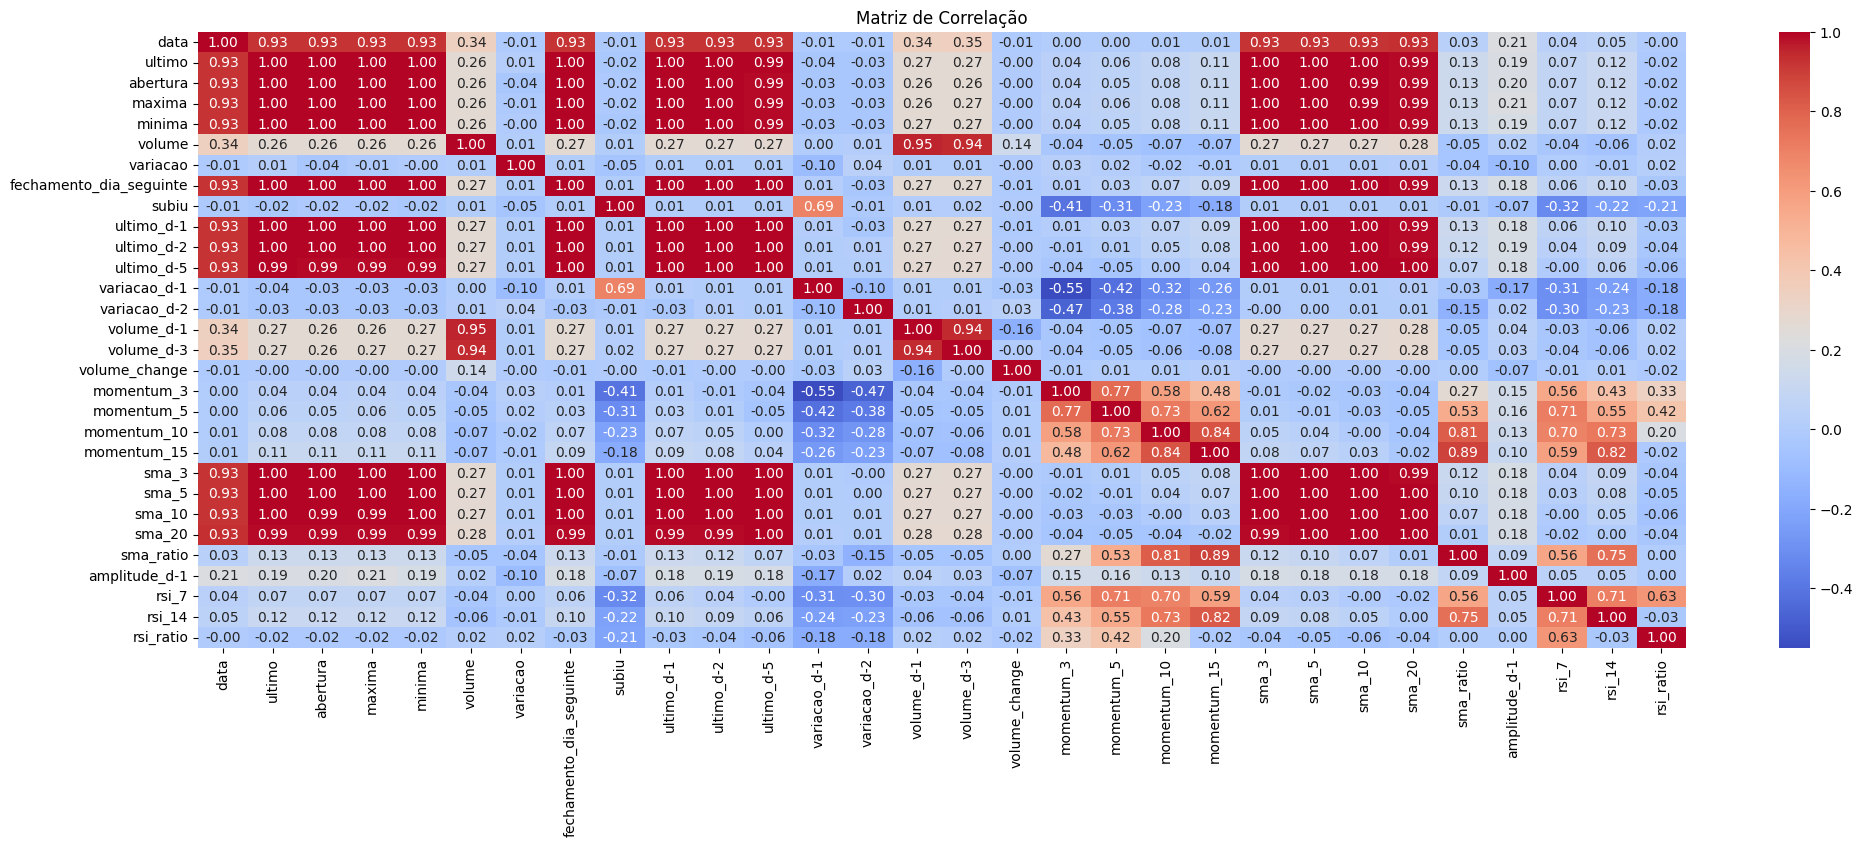

In [355]:
# gerando uma matriz de correlação para entender como as variáveis se conversam
correlation_matrix = dados.corr()
plt.figure(figsize=(24, 8))# DESCRIÇÃO ESTATISCAS DAS VARIAVEIS
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

## **Regressão Logística (Utilizando Todas as Novas Features)**

In [356]:
# Ordenar do mais antigo para o mais recente
dados_erick = dados.sort_values(by='data').reset_index(drop=True)

# Definir data de corte: 30 dias antes da data mais recente
data_corte = dados_erick['data'].max() - pd.DateOffset(days=30)

# LAGs
dados_erick['ultimo_d-1'] = dados_erick['ultimo'].shift(1)
dados_erick['ultimo_d-2'] = dados_erick['ultimo'].shift(2)
dados_erick['ultimo_d-5'] = dados_erick['ultimo'].shift(5)

dados_erick['variacao_d-1'] = dados_erick['variacao'].shift(1)
dados_erick['variacao_d-2'] = dados_erick['variacao'].shift(2)

dados_erick['volume_d-1'] = dados_erick['volume'].shift(1)
dados_erick['volume_d-3'] = dados_erick['volume'].shift(3)

#
dados_erick['volume_change'] = dados_erick['volume'] - dados_erick['volume'].shift(1)

# Momentum
dados_erick['momentum_3'] = dados_erick['ultimo'] - dados_erick['ultimo'].shift(3)
dados_erick['momentum_5'] = dados_erick['ultimo'] - dados_erick['ultimo'].shift(5)
dados_erick['momentum_10'] = dados_erick['ultimo'] - dados_erick['ultimo'].shift(10)
dados_erick['momentum_15'] = dados_erick['ultimo'] - dados_erick['ultimo'].shift(15)

# SMA
dados_erick['sma_3'] = dados_erick['ultimo'].rolling(3).mean().shift(1)
dados_erick['sma_5'] = dados_erick['ultimo'].rolling(5).mean().shift(1)
dados_erick['sma_10'] = dados_erick['ultimo'].rolling(10).mean().shift(1)
dados_erick['sma_20'] = dados_erick['ultimo'].rolling(20).mean().shift(1)

dados_erick['ema_15'] = dados_erick['ultimo'].ewm(span=15, adjust=False).mean()
dados_erick['ema_25'] = dados_erick['ultimo'].ewm(span=25, adjust=False).mean()
dados_erick['ema_50'] = dados_erick['ultimo'].ewm(span=50, adjust=False).mean()
dados_erick['ema_72'] = dados_erick['ultimo'].ewm(span=72, adjust=False).mean()

# Compara a média móvel de 5 dias com a de 20 dias.
dados_erick['sma_ratio'] = dados_erick['sma_3'] / dados_erick['sma_20']

# Amplitude
dados_erick['amplitude_d-1'] = (dados_erick['maxima'] - dados_erick['minima']).shift(1)

# RSI
for janela in [7, 14]:
    delta = dados_erick['ultimo'].diff()
    ganhos = delta.clip(lower=0)
    perdas = -delta.clip(upper=0)

    media_ganhos = ganhos.rolling(janela).mean()
    media_perdas = perdas.rolling(janela).mean()
    rs = media_ganhos / media_perdas
    dados_erick[f'rsi_{janela}'] = 100 - (100 / (1 + rs))

# Compara a força relativa de curto prazo com a de médio prazo.
dados_erick['rsi_ratio'] = dados_erick['rsi_7'] / dados_erick['rsi_14']

dados_erick = dados_erick.dropna().reset_index(drop=True)

In [357]:
# Separando os dados a serem analisados pelo modelo
features = ['ultimo', 'abertura', 'maxima', 'minima','ultimo_d-1', 'ultimo_d-2', 'ultimo_d-5', 'variacao_d-1', 'variacao_d-2', 'volume_d-1', 'volume_d-3','volume_change', 'momentum_3',
             'momentum_5', 'momentum_10','momentum_15', 'sma_3', 'sma_5', 'sma_10', 'sma_20', 'sma_ratio', 'amplitude_d-1', 'rsi_7', 'rsi_14', 'rsi_ratio']

#features = ['ultimo','abertura','maxima','minima',
#           'sma_3','sma_5','sma_10',
#          'ema_25','ema_15']

target = 'subiu'

x = dados_erick[features]
y = dados_erick[target]

# Separar treino e teste
dados_treino = dados_erick[dados_erick['data'] <= data_corte]
dados_teste = dados_erick[dados_erick['data'] > data_corte]

# Separar x e y
x_train = dados_treino[features]
y_train = dados_treino[target]
x_test = dados_teste[features]
y_test = dados_teste[target]

# Normalizando os dados
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Inserindo os dados no modelo
modelo = LogisticRegression()
modelo.fit(x_train_scaled, y_train)

# Iniciando a fase de teste
previsoes = modelo.predict(x_test_scaled)

# Imprimindo os resultados
print("Acurácia:", accuracy_score(y_test, previsoes))
print("Matriz de confusão:")
print(confusion_matrix(y_test, previsoes))
print("\nRelatório de classificação:")
print(classification_report(y_test, previsoes))

Acurácia: 0.5909090909090909
Matriz de confusão:
[[ 3  9]
 [ 0 10]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.53      1.00      0.69        10

    accuracy                           0.59        22
   macro avg       0.76      0.62      0.54        22
weighted avg       0.78      0.59      0.53        22



## **Random Forest (Utilizando Todas as Novas Features)**

In [358]:
# prompt: random forest

from sklearn.ensemble import RandomForestClassifier
# Inserindo os dados no modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42) # You can tune n_estimators and other parameters
modelo_rf.fit(x_train_scaled, y_train)
# Iniciando a fase de teste
previsoes_rf = modelo_rf.predict(x_test_scaled)
# Imprimindo os resultados
print("Acurácia (Random Forest):", accuracy_score(y_test, previsoes_rf))
print("Matriz de confusão (Random Forest):")
print(confusion_matrix(y_test, previsoes_rf))
print("\nRelatório de classificação (Random Forest):")
print(classification_report(y_test, previsoes_rf))

Acurácia (Random Forest): 0.5909090909090909
Matriz de confusão (Random Forest):
[[8 4]
 [5 5]]

Relatório de classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.56      0.50      0.53        10

    accuracy                           0.59        22
   macro avg       0.59      0.58      0.58        22
weighted avg       0.59      0.59      0.59        22



In [359]:
print(dados['subiu'].value_counts(normalize=True))

subiu
1    0.523635
0    0.476365
Name: proportion, dtype: float64


<p>Percebe-se que as features novas não foram capazes de auxiliar o modelo de forma que alcançasse a acurácia mínima proposta. Portanto, faz-se necessário o ajuste dessas variáveis.</p>

## **Analise de Médias Moveis**

In [360]:
# Adicionando nova coluna dia_semana

df = dados.copy()

In [361]:
# EMA
df['ema_15'] = df['ultimo'].ewm(span=15, adjust=False).mean()
df['ema_25'] = df['ultimo'].ewm(span=25, adjust=False).mean()
df['ema_50'] = df['ultimo'].ewm(span=50, adjust=False).mean()
df['ema_72'] = df['ultimo'].ewm(span=72, adjust=False).mean()

df = df.dropna().reset_index(drop=True)

In [362]:
# Lista de colunas
df.columns

Index(['data', 'ultimo', 'abertura', 'maxima', 'minima', 'volume', 'variacao',
       'fechamento_dia_seguinte', 'subiu', 'ultimo_d-1', 'ultimo_d-2',
       'ultimo_d-5', 'variacao_d-1', 'variacao_d-2', 'volume_d-1',
       'volume_d-3', 'volume_change', 'momentum_3', 'momentum_5',
       'momentum_10', 'momentum_15', 'sma_3', 'sma_5', 'sma_10', 'sma_20',
       'sma_ratio', 'amplitude_d-1', 'rsi_7', 'rsi_14', 'rsi_ratio', 'ema_15',
       'ema_25', 'ema_50', 'ema_72'],
      dtype='object')

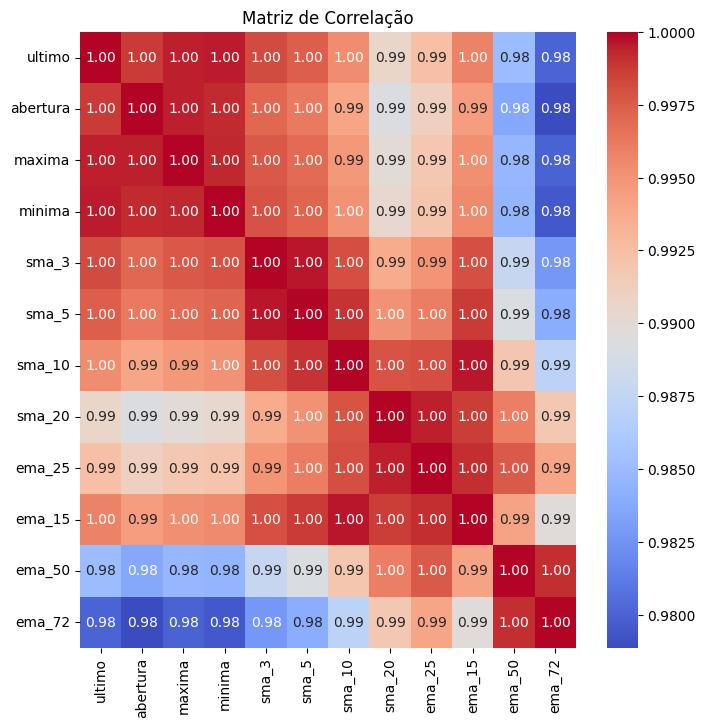

In [363]:
# Correlação de colunas
colunas = ['ultimo','abertura','maxima','minima','sma_3','sma_5','sma_10','sma_20','ema_25','ema_15','ema_50','ema_72']

correlation_matrix = df[colunas].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

<p>Percebe-se que as médias móveis: sma_3, sma_5, sma_10, ema_25, ema_15 são as que possuem maior correlação, e que podem impactar de forma positiva na predição da variável target.</p>

### **Regressão Logística - Features de Forte Correlação**

In [364]:
# Separando os dados a serem analisados pelo modelo
features = ['ultimo','abertura','maxima','minima',
            'sma_3','sma_5','sma_10',
            'ema_25','ema_15']

target = 'subiu'

x = df[features]
y = df[target]

# Separar treino e teste
# df_treino = df[df['data'] <= data_corte]
# dados_teste = df[df['data'] > data_corte]
df_treino = df[df['data'] <= data_corte]
df_teste = df[df['data'] > data_corte]

# Separar x e y
# Remove the 'data' column from features for scaling
features_for_scaling = [col for col in features if col != 'data']

x_train = df_treino[features_for_scaling]
y_train = df_treino[target]

x_test = df_teste[features_for_scaling]
y_test = df_teste[target]

# Normalizando os dados
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Inserindo os dados no modelo
modelo = LogisticRegression()
modelo.fit(x_train_scaled, y_train)

# Iniciando a fase de teste
previsoes_teste = modelo.predict(x_test_scaled)

# Fazendo previsões no conjunto de treino para verificar overfitting
previsoes_treino = modelo.predict(x_train_scaled)

# Imprimindo os resultados
print("Acurácia no conjunto de TREINO:", accuracy_score(y_train, previsoes_treino))
print("Acurácia no conjunto de TESTE:", accuracy_score(y_test, previsoes_teste))
print("\nMatriz de confusão (TESTE):")
print(confusion_matrix(y_test, previsoes_teste))
print("\nRelatório de classificação (TESTE):")
print(classification_report(y_test, previsoes_teste))

Acurácia no conjunto de TREINO: 0.7582236842105263
Acurácia no conjunto de TESTE: 0.7727272727272727

Matriz de confusão (TESTE):
[[9 3]
 [2 8]]

Relatório de classificação (TESTE):
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.73      0.80      0.76        10

    accuracy                           0.77        22
   macro avg       0.77      0.78      0.77        22
weighted avg       0.78      0.77      0.77        22



### **Random Forest - Features de Forte Relação**

In [365]:
from sklearn.ensemble import RandomForestClassifier

# Definindo o modelo com hiperparâmetros ajustados
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(x_train_scaled, y_train)

# Iniciando a fase de treino
previsoes_treino_rf = modelo_rf.predict(x_train_scaled)

# Iniciando a fase de teste
previsoes_teste_rf = modelo_rf.predict(x_test_scaled)

# Imprimindo os resultados
print("Acurácia (Treino):", accuracy_score(y_train, previsoes_treino_rf))
print("Acurácia (Teste):", accuracy_score(y_test, previsoes_teste_rf))
print("Matriz de confusão (Teste):")
print(confusion_matrix(y_test, previsoes_teste_rf))
print("\nRelatório de classificação (Teste):")
print(classification_report(y_test, previsoes_teste_rf))

Acurácia (Treino): 0.7680921052631579
Acurácia (Teste): 0.45454545454545453
Matriz de confusão (Teste):
[[ 0 12]
 [ 0 10]]

Relatório de classificação (Teste):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.45      1.00      0.62        10

    accuracy                           0.45        22
   macro avg       0.23      0.50      0.31        22
weighted avg       0.21      0.45      0.28        22



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<p>É possível identificar que o modelo de regressão logística superou a meta mínima de acurácia sugerida. </p>

# **Conclusão**

<p>Neste projeto, foi desenvolvido um modelo de machine learning para prever a direção do índice IBOVESPA no pregão seguinte (alta ou queda). Após etapas de pré-processamento, engenharia de atributos e avaliação de diferentes algoritmos, o modelo que apresentou o melhor desempenho foi a Regressão Logística, com uma acurácia de aproximadamente 77,2% no conjunto de teste.

Esse resultado atende ao requisito mínimo estabelecido pelo desafio e demonstra que, apesar de ser um modelo mais simples, a Regressão Logística conseguiu capturar padrões relevantes quando combinada com atributos bem construídos, como as médias móveis.

Além disso, a diferença moderada entre o desempenho nos conjuntos de treino (75,8%) e teste indica que o modelo possui boa capacidade de generalização e não está sofrendo de overfitting.

Este trabalho reforça a importância de uma engenharia de atributos cuidadosa e do uso de abordagens supervisionadas simples, mas eficientes, para problemas de previsão em séries temporais financeiras.</p>